# World Navigation with DQN - Tuned


This is a bonus task where this DQN is tuned.

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

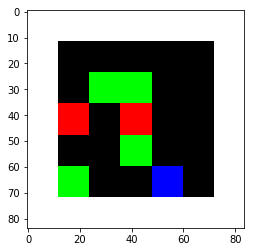

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

In [3]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [4]:
def processState(states):
    return np.reshape(states,[21168]) # 84 x 84 x 3

These functions allow us to update the parameters of our target network with those of the primary network.

In [5]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Implementing the network itself

In [6]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        #We use slim.conv2d to set up our network 
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        ################################################################################
        # TODO: Implement Dueling DQN                                                  #
        # We take the output from the final convolutional layer i.e. self.conv4 and    #
        # split it into separate advantage and value streams.                          #
        # Outout: self.Advantage, self.Value                                           #
        # Hint: Refer to Fig.1 in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)  #
        #       In implementation, use tf.split to split into two branches. You may    #
        #       use xavier_initializer for initializing the two additional linear      #
        #       layers.                                                                # 
        ################################################################################
        adv, val = tf.split(self.conv4, 2, 3)
        self.Advantage = tf.layers.dense(slim.flatten(adv), env.actions)
        self.Value = tf.layers.dense(slim.flatten(val), 1)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        #Then combine them together to get our final Q-values. 
        #Please refer to Equation (9) in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        ################################################################################
        # TODO:                                                                        #
        # Obtain the loss (self.loss) by taking the sum of squares difference          #
        # between the target and prediction Q values.                                  #
        ################################################################################
        predictQ = tf.reduce_sum(self.Qout*self.actions_onehot,axis = 1)
        self.loss = tf.reduce_mean((predictQ - self.targetQ)**2)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Training the network

Setting all the training parameters

In [7]:
batch_size = 64 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 5000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 100 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            total_steps += 1
            
            ################################################################################
            # TODO: Save the experience to our episode buffer.                             #
            # You will need to do the following:                                           #
            # (1) Get new state s1 (resized), reward r and done d from a                   #
            # (2) Add experience to episode buffer. Hint: experience includes              #
            #     s, a, r, s1 and d.                                                       #
            ################################################################################
            s1, r, d = env.step(a)
            s1 = processState(s1)
            experience = np.expand_dims(np.array([s, a, r, s1, d]), 0)
            episodeBuffer.add(experience)   
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    
                    ################################################################################
                    # TODO: Implement Double-DQN                                                   #
                    # (1) Get a random batch of experiences via experience_buffer class            #
                    #                                                                              #
                    # (2) Perform the Double-DQN update to the target Q-values                     #
                    #     Hint: Use mainQN and targetQN separately to chose an action and predict  #
                    #     the Q-values for that action.                                            #
                    #     Then compute targetQ based on Double-DQN equation                        #
                    #                                                                              #
                    # (3) Update the primary network with our target values                        #
                    ################################################################################ 
                    batch = myBuffer.sample(batch_size)
                    
                    stacked_state = np.vstack(batch[:, 3])
                    
                    action_ = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: stacked_state})
                    Q_ = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput: stacked_state})
                    next_Q = Q_[range(batch_size), action_]
                    
                    done_mask = 1 - batch[:, 4]
                    targetQ = batch[:, 2] + done_mask * y * next_Q
                    
                    sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput: np.vstack(batch[:,0]), 
                                                             mainQN.targetQ: targetQ, 
                                                             mainQN.actions: batch[:,1]})
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
                           
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
print("Mean reward per episode: " + str(sum(rList)/num_episodes))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Episode 9 reward: 2.8
Episode 19 reward: 4.4
Episode 29 reward: 2.8
Episode 39 reward: 3.3
Episode 49 reward: 3.5
Episode 59 reward: 3.3
Episode 69 reward: 2.8
Episode 79 reward: 3.3
Episode 89 reward: 3.6
Episode 99 reward: 4.4
Episode 109 reward: 3.1
Episode 119 reward: 4.5
Episode 129 reward: 3.2
Episode 139 reward: 5.8
Episode 149 reward: 4.6
Episode 159 reward: 4.0
Episode 169 reward: 5.4
Episode 179 reward: 4.7
Episode 189 reward: 5.3
Episode 199 reward: 5.6
Episode 209 reward: 6.0
Episode 219 reward: 8.0
Episode 229 reward: 6.1
Episode 239 reward: 4.0
Episode 249 reward: 7.4
Episode 259 reward: 11.8
Episode 269 reward: 9.7
Episode 279 reward: 11.8
Episode 289 reward: 13.6
Episode 299 reward: 10.8
Episode 309 reward: 13.6
Episode 319 reward: 22.3
Episode 329 reward: 17.2
Episode 339 reward: 19.9
Episode 349 reward: 21.6
Episode 359 reward: 17.3
Episode 369 reward: 18.3
Episode 379 reward: 23.4
Episode 389 re

Originally the mean reward is ~19, now it is ~ 37.5, almost a x2 improvement.

### Checking network learning

Mean reward over time

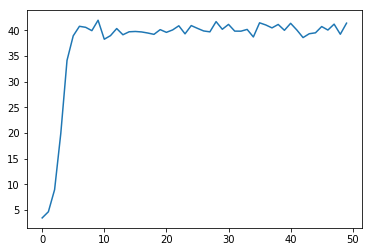

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)